In [62]:
import os
import glob
import numpy as np
import pandas as pd
import requests
import time
from datetime import datetime, date, time, timedelta
from typing import Tuple, Union, Optional
from itertools import chain


# for ML models:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler

# for visualization
import matplotlib.pyplot as plt
import seaborn as sns
from bokeh.plotting import figure, show, save, output_file
from bokeh.palettes import Category20
from bokeh.models.widgets import PreText
from bokeh.models import BooleanFilter, ColumnDataSource, IndexFilter, BoxAnnotation, Band, Span, Select, LinearAxis, DataRange1d, Range1d
from bokeh.models.formatters import PrintfTickFormatter, NumeralTickFormatter
from bokeh.layouts import column


# for Data
import yfinance as yf


In [57]:
WIDTH_PLOT = 1500

RED = Category20[7][6]
GREEN = Category20[5][4]

BLUE = Category20[3][0]
BLUE_LIGHT = Category20[3][1]

ORANGE = Category20[3][2]
PURPLE = Category20[9][8]
BROWN = Category20[11][10]

# TOOLS = 'pan,wheel_zoom,reset'
TOOLS = "pan,wheel_zoom,box_zoom,reset,save"


The data was extracted from yfinance, we chose IVV ticker for S&P 500 ETF, since its investable.\
the yfinance data inclused the Adjusted return column: a calculation adjustment made to a stock’s closing price.\
The original closing price does not exemplify the most accurate valuation of the stock or security since it will not account for any actions that could’ve caused the price to shift. Therefore, an adjusted closing price will include any adjustments that need to be made to the price\
The adjustments made are to compensate for anything that could’ve affected the stock’s value, such as a corporate action. The corporate actions can include dividends or stock splits. The adjustment made to the closing price will display the true price of the stock or security because certain outside factors could’ve altered the true price.\
LOG-RETURN: https://medium.datadriveninvestor.com/why-we-use-log-returns-for-stock-returns-820cec4510ba \
log returns are the preferred way to model stock returns, as proven in this article

In [30]:
# Ticker symbol for iShares Core S&P 500 ETF (IVV)
ticker_symbol = "IVV"

# Extracting data
ivv_data = yf.download(ticker_symbol, start="2002-01-01", end="2024-01-01", interval="1d")
# https://corporatefinanceinstitute.com/resources/equities/adjusted-closing-price/
ivv_data['Return'] = np.log(ivv_data['Adj Close'].shift(1))
# Displaying the first few rows of the data
print(ivv_data.head())
ivv_data.info()

[*********************100%***********************]  1 of 1 completed
                  Open        High         Low       Close  Adj Close  Volume  \
Date                                                                            
2002-01-02  115.000000  115.570000  113.860001  115.449997  75.894157  987900   
2002-01-03  115.449997  116.779999  115.449997  116.779999  76.768486  359500   
2002-01-04  117.120003  117.860001  116.550003  117.599998  77.307526  154100   
2002-01-07  117.599998  117.959999  116.599998  116.709999  76.722481  220900   
2002-01-08  116.739998  117.019997  116.019997  116.230003  76.406937  124300   

              Return  
Date                  
2002-01-02       NaN  
2002-01-03  4.329340  
2002-01-04  4.340794  
2002-01-07  4.347791  
2002-01-08  4.340195  
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5537 entries, 2002-01-02 to 2023-12-29
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  ----- 

In [4]:
ivv_data.describe(include='all')

,Open,High,Low,Close,Adj Close,Volume,Return
count,5537.000000,5537.000000,5537.000000,5537.000000,5537.000000,5.537000e+03,5536.000000
mean,204.134851,205.267334,202.882379,204.157000,176.793921,3.473057e+06,4.979741
std,108.970042,109.540483,108.366692,108.996600,115.614782,2.728486e+06,0.613574
min,68.160004,70.129997,67.220001,68.190002,51.105194,4.490000e+04,3.933886
25%,119.559998,120.150002,118.870003,119.599998,86.645630,1.717800e+06,4.461806
50%,153.220001,153.669998,152.330002,152.970001,119.062103,3.137300e+06,4.778736
75%,272.839996,274.760010,270.980011,272.730011,246.639389,4.590100e+06,5.507856
max,481.369995,482.070007,478.519989,479.839996,477.479950,3.874850e+07,6.168522


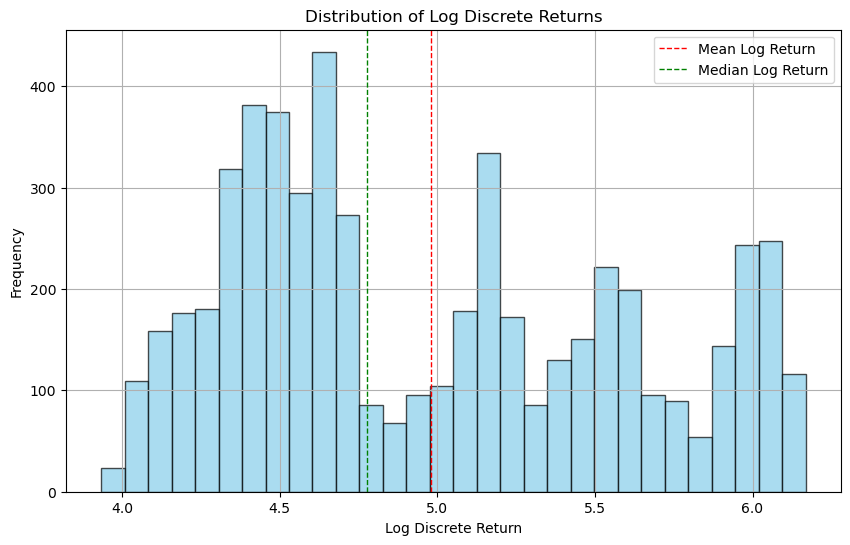

In [5]:
# chach for imbalance in the return: if Skewness is high?
log_returns = ivv_data['Return']


# Plot histogram of log discrete returns
plt.figure(figsize=(10, 6))
plt.hist(log_returns, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Log Discrete Returns')
plt.xlabel('Log Discrete Return')
plt.ylabel('Frequency')
plt.grid(True)

# Add a vertical line indicating the mean of log discrete returns
mean_log_return = log_returns.mean()
plt.axvline(mean_log_return, color='red', linestyle='dashed', linewidth=1, label='Mean Log Return')
median_log_return = log_returns.median()
plt.axvline(median_log_return, color='green', linestyle='dashed', linewidth=1, label='Median Log Return')
# Show legend
plt.legend()

plt.show()

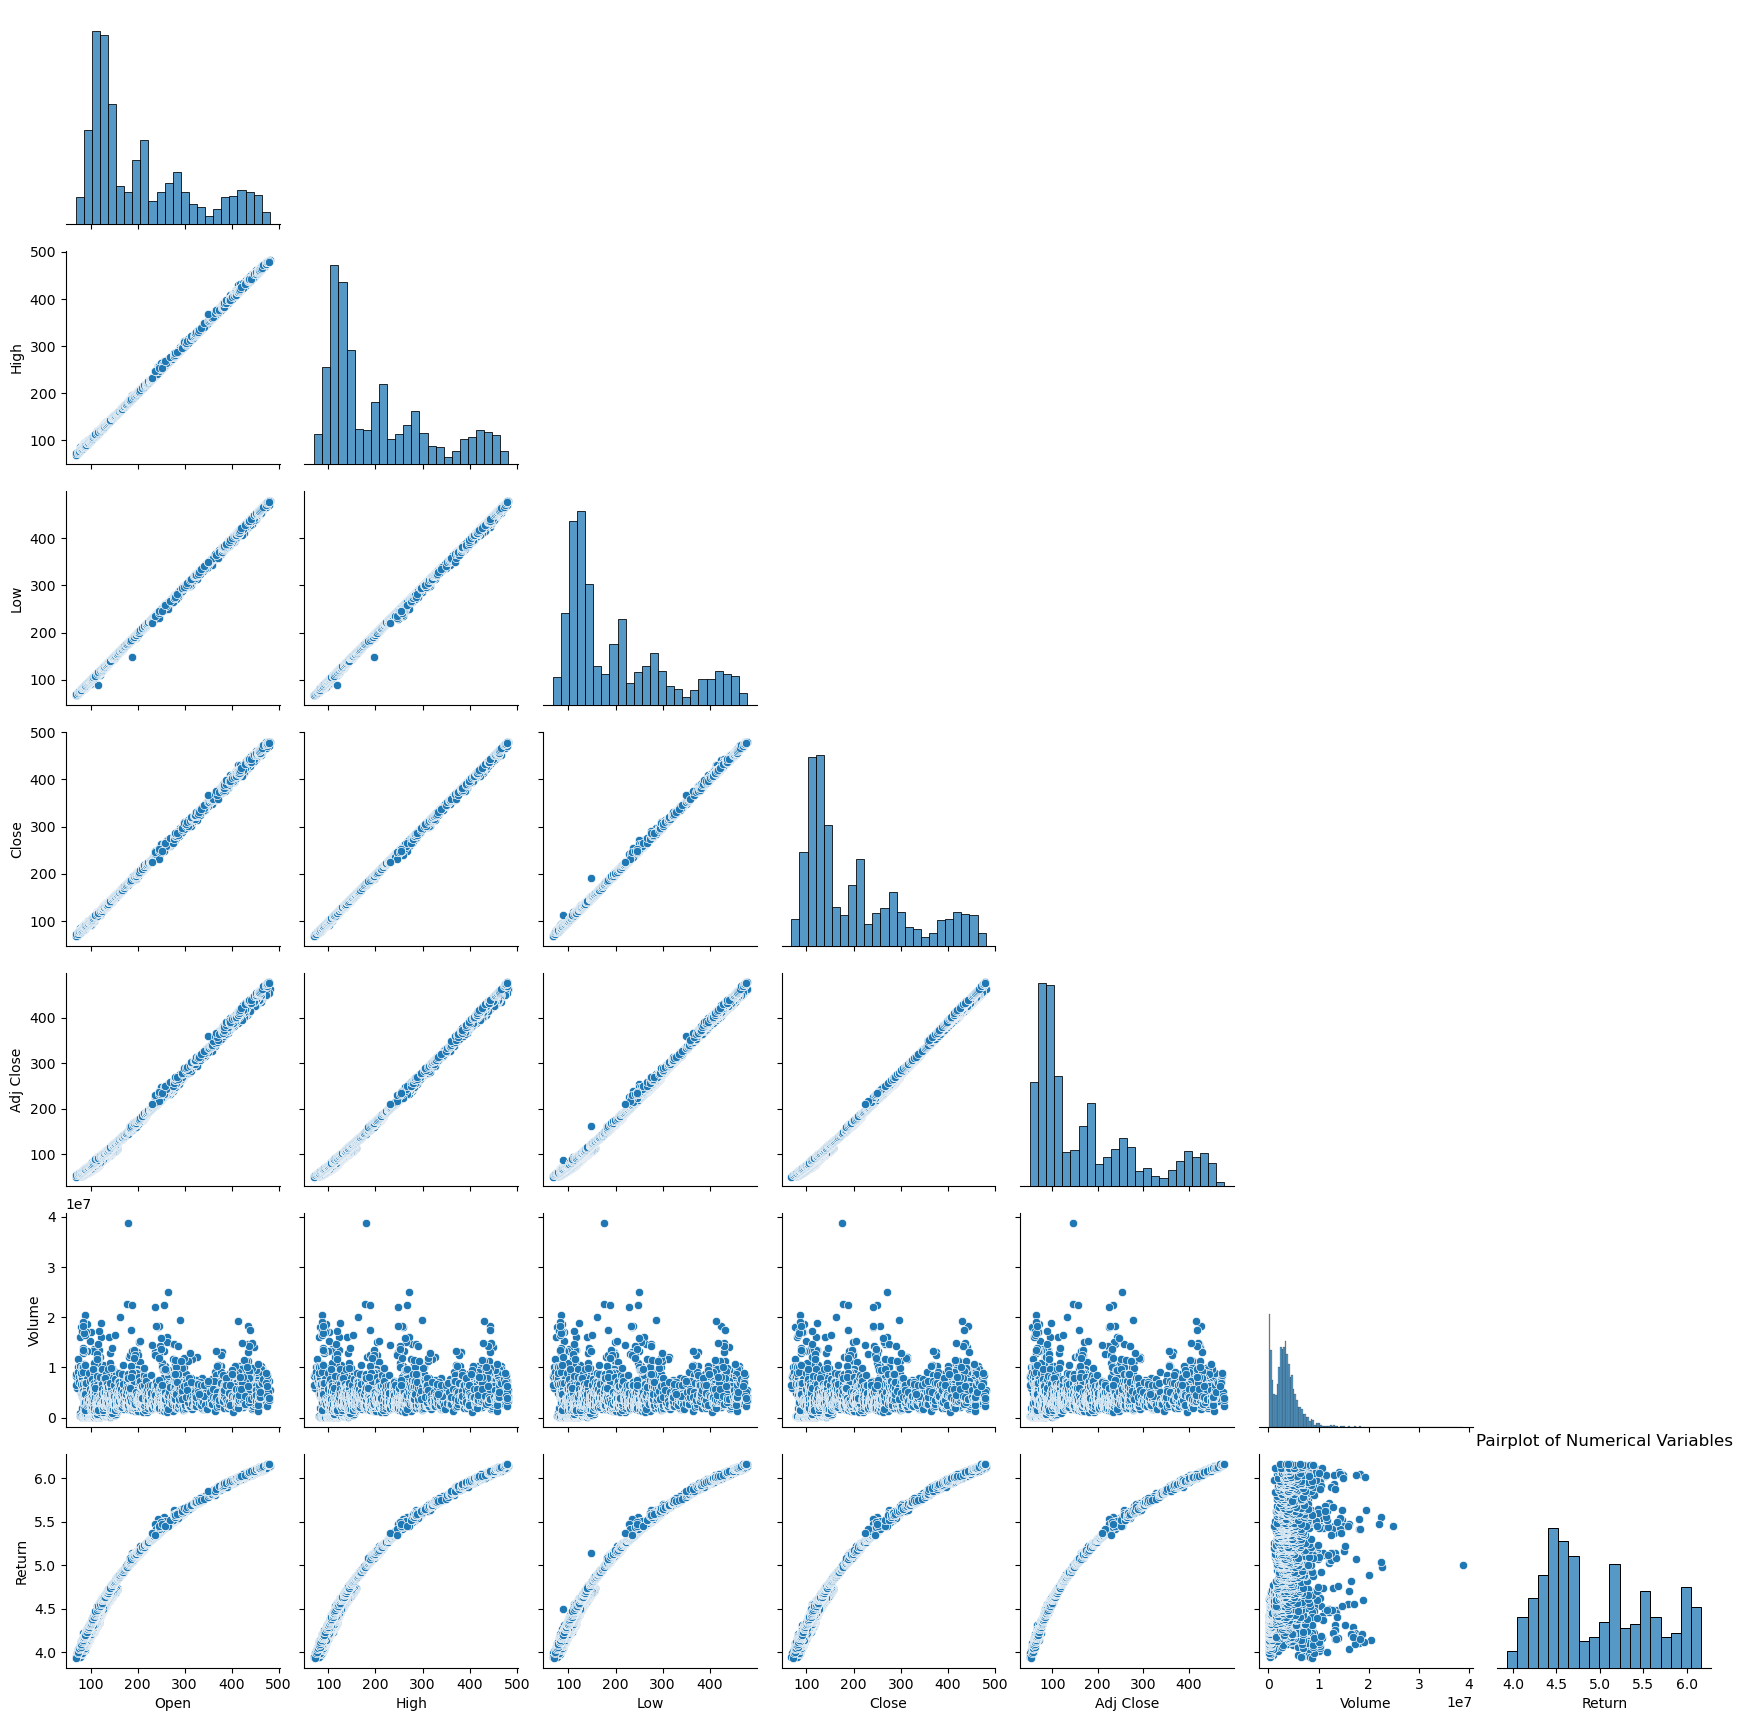

In [6]:
# Pairplot to visualize relationships between numerical variables: No skewness in data -- > low imbalance
sns.pairplot(ivv_data, corner=True)
plt.title('Pairplot of Numerical Variables')
plt.show()

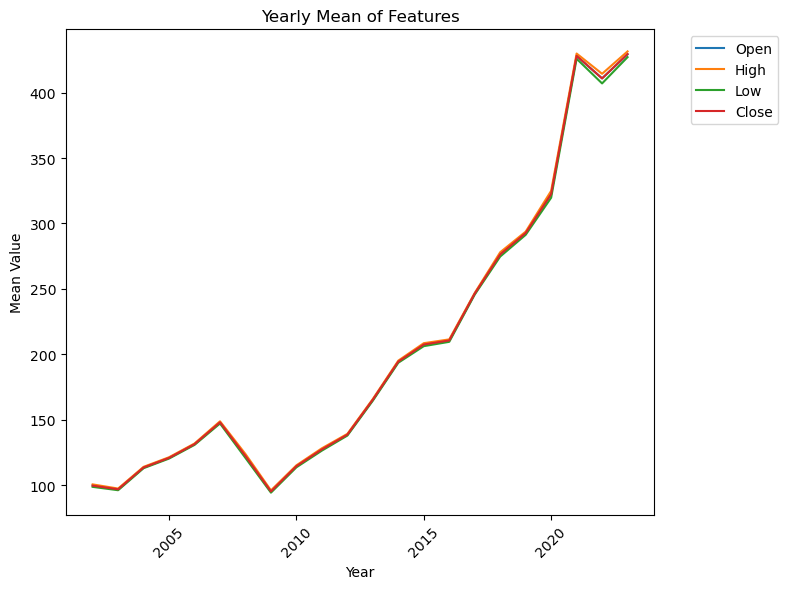

In [7]:
df_A = ivv_data.copy()

# Extract year from the 'DATE' column
df_A['Year'] = df_A.index.year

# Aggregate data by year and compute the mean for each feature
yearly_data = df_A[['Year','Open', 'High', 'Low', 'Close']].groupby('Year').mean()

# Reset index to have 'Year' as a regular column
yearly_data.reset_index(inplace=True)

# Melt the DataFrame to have a single x-axis for all features
melted_yearly_data = yearly_data.melt(id_vars=['Year'], var_name='Feature', value_name='Mean Value')

# Create a line plot
plt.figure(figsize=(8, 6))
sns.lineplot(data=melted_yearly_data, x='Year', y='Mean Value', hue='Feature')
plt.title('Yearly Mean of Features')
plt.xlabel('Year')
plt.ylabel('Mean Value')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Volatility Indicators:\
Volatility can be measured in a number of ways, including VIX, ATR, and Bollinger Bands to determine optimal exit or entry points for trades. While high volatility is often a deterrent for a risky trade, increased fear during extreme market moves and larger price swings can also create buying opportunities and provide an exceptional trading ground for experienced investors.\
Daily variation: a measure of volatility, or how much a stock's value changes.It is the difference between its highest and lowest values on a given trading day. A stock with a very large daily price variation is very volatile and may be expected to change its value quickly over time. When daily price variations are small, it indicates more consensus within the market about the value of the stock. Stable daily price variations over time show that a stock is unlikely to shoot up or plummet in value on any given day.\
Average True Range (ATR) is the average of true ranges over the specified period. ATR measures volatility, taking into account any gaps in the price movement. Typically, the ATR calculation is based on 14 periods, which can be intraday, daily, weekly, or monthly. ATR is very useful for stops or entry triggers, signaling changes in volatility. Whereas fixed dollar- point or percentage stops will not allow for volatility, the ATR stop will adapt to sharp price moves or consolidation areas, which can trigger an abnormal price movement in either direction.\

Bollinger Band : designed to give investors a higher probability of identifying when an asset is oversold or overbought. Three lines compose Bollinger Bands: A simple moving average, or the middle band, and an upper and lower band. Many traders believe the closer the prices move to the upper band, the more overbought the market, and the closer the prices move to the lower band, the more oversold the market./



In [9]:
# Volatility Indicators

# verage True Range (ATR)
def calculate_atr(open_price, high, low):
    daily_variation = (high - low) / open_price
    return daily_variation.rolling(window=14).mean()

# Bollinger Band
def calculate_bollinger_bands(close_prices: np.ndarray, window: int, num_std=2):
    """
    Calculate the Bollinger Bands for a given set of closing prices.

    Parameters:
    - close_prices: List or array of closing prices
    - window: Size of the moving average window (default is 20)
    - num_std: Number of standard deviations for the bands (default is 2)

    Returns:
    - bollinger_upper: List of upper Bollinger Band values
    - bollinger_lower: List of lower Bollinger Band values
    """
    close_series = pd.Series(close_prices)
    sma = close_series.rolling(window=window).mean()
    rolling_std = close_series.rolling(window=window).std()

    bollinger_upper = sma + (rolling_std * num_std)
    bollinger_lower = sma - (rolling_std * num_std)

    return round(bollinger_upper,2), round(sma, 2), round(bollinger_lower,2)

def calculate_bollinger_width(bollinger_upper, sma, bollinger_lower):
    return (bollinger_upper - bollinger_lower) / sma

In [53]:
# Main chart for stock prices with candlestick and Bolinger bands
def plot_stock_price(stock):
    p = figure(x_axis_type="datetime", width=WIDTH_PLOT, height=400,
               title="Stock price + Bollinger Bands (2 std)",
               tools=TOOLS, toolbar_location='above')

    inc_data = stock[stock['Close'] > stock['Open']]
    dec_data = stock[stock['Open'] > stock['Close']]

    width = 35000000

    p.segment(x0='Date', x1='Date', y0='Low', y1='High', color=RED, source=inc_data)
    p.segment(x0='Date', x1='Date', y0='Low', y1='High', color=GREEN, source=dec_data)

    p.vbar(x='Date', width=width, top='Open', bottom='Close', fill_color=RED, line_color=RED,
           source=inc_data)
    p.vbar(x='Date', width=width, top='Open', bottom='Close', fill_color=GREEN, line_color=GREEN,
           source=dec_data)

    # Plot Simple Moving Average
    p.line(x='Date', y='sma', line_width=2, color=BLUE, line_alpha=0.7,source=stock)
    
    # Creating vertices for the cloud-like shape between Bollinger Bands
    cloud_x = list(stock['Date']) + list(stock['Date'][::-1])
    cloud_y = list(stock['bolling_upper']) + list(stock['bolling_lower'][::-1])

    cloud_source = ColumnDataSource(data=dict(x=cloud_x, y=cloud_y))

    # Creating the patch for the cloud-like shape
    p.patch('x', 'y', color=BLUE_LIGHT, line_color='black', alpha=0.3, source=cloud_source)

    code = """
    def ticker():
        return "{:.0f} + {:.2f}".format(tick, tick % 1)
    """
    p.yaxis.formatter = NumeralTickFormatter(format='$ 0,0[.]000')

    return p

def plot_bbw(stock):
    # Create the sub-plot for Bollinger Band Width
    p_sub = figure(x_axis_type="datetime", width=WIDTH_PLOT, height=200,
                   title="Bollinger Band Width",
                   tools=TOOLS, toolbar_location='above')

    # Plot Bollinger Band Width
    p_sub.line(x='Date', y='bbw', line_width=2, color='orange', source=stock)
    
    return p_sub

def plot_atr(stock):
    # Create the sub-plot for Bollinger Band Width
    p_sub = figure(x_axis_type="datetime", width=WIDTH_PLOT, height=200,
                   title="Average True Range (ATR)",
                   tools=TOOLS, toolbar_location='above')

    # Plot Bollinger Band Width
    p_sub.line(x='Date', y='atr', line_width=2, color='purple', source=stock)
    
    return p_sub

In [63]:
# Visualize Volatility:
vis1_df = ivv_data
vis1_df['bolling_upper'], vis1_df['sma'], vis1_df['bolling_lower'] = calculate_bollinger_bands(vis1_df['Close'], window=15)
vis1_df['bbw'] = calculate_bollinger_width(vis1_df['bolling_upper'], vis1_df['sma'], vis1_df['bolling_lower'])
vis1_df['atr'] = calculate_atr(vis1_df['Open'], vis1_df['High'], vis1_df['Low'])

p = plot_stock_price(vis1_df.dropna())
p_sub = plot_bbw(vis1_df.dropna())
p_sub2 = plot_atr(vis1_df.dropna())
# Combine the plots
plot_combined = column(p, p_sub, p_sub2)
show(plot_combined)


'/Users/rashajaber/Investor/notebooks/custom_filename.html'

In [7]:

# Base level analyzed for parameter representing the number of periods n = 15 as proposed by https://www.sciencedirect.com/science/article/pii/S2405918815300179


# Bollinger band width indicator

# Weighted Moving Average
# calculate for 15 days
def calculate_wma(close_prices: np.ndarray, window: int) -> np.ndarray:
    
    weights = np.arange(1, window + 1)
    wma =  close_prices.rolling(window=window).apply(lambda price: np.dot(close_prices, weights) / weights.sum(), raw=True)

    return wma.values

# Exponential Moving Average: to reduce lag in responsiveness to price movements.
# calculate for 12, 15, 26
def calculate_ema(close_prices: np.ndarray, window: int) -> np.ndarray:
    return close_prices.ewm(span=window, adjust=False).mean()


# distant of the current price is from MA's
def signal_dist_ma(close_prices: np.ndarray, ma: np.ndarray) -> np.ndarray:
    return close_prices - ma
# sma_15_signal = df['CLOSE'] -  sma_15
# wma_15_signal = df['CLOSE'] - wma_15
# ema_15_signal = df['CLOSE'] - wma_15


def calculate_dmi(high, low, close):
    high_shifted = high.shift(1)
    low_shifted = low.shift(1)
    dm_plus = high - high_shifted
    dm_minus = low_shifted - low
    dm_plus[dm_plus < 0] = 0
    dm_minus[dm_minus < 0] = 0
    tr = high - low
    atr = tr.rolling(window=14).mean()
    di_plus = (dm_plus / atr).rolling(window=14).mean() * 100
    di_minus = (dm_minus / atr).rolling(window=14).mean() * 100
    dx = np.abs(di_plus - di_minus) / (di_plus + di_minus) * 100
    return dx



In [8]:
# On-Balance Volume (OBV)
def calculate_obv(close_prices: np.ndarray, volume: np.ndarray) -> np.ndarray:
    """
    Calculate the On-Balance Volume (OBV) for a given set of closing prices and volume.

    Parameters:
    - close_prices: List or array of closing prices
    - volume: List or array of trading volume corresponding to the closing prices

    Returns:
    - obv_values: List of On-Balance Volume (OBV) values
    """
    obv_values = [0]  # Initialize OBV with zero

    for i in range(1, len(close_prices)):
        if close_prices[i] > close_prices[i - 1]:
            obv_values.append(obv_values[i - 1] + volume[i])  # Add volume to OBV for uptrend
        elif close_prices[i] < close_prices[i - 1]:
            obv_values.append(obv_values[i - 1] - volume[i])  # Subtract volume from OBV for downtrend
        else:
            obv_values.append(obv_values[i - 1])  # No change in OBV for no price change

    return obv_values



In [10]:
# Oscillators

# Moving Average Convergence Divergence
def calculate_macd(close_prices:np.ndarray, 
                   short_window: int, 
                   long_window: int, 
                   signal_window: int):
    # Calculate short-term (fast) EMA
    short_ema = close_prices.ewm(span=short_window, min_periods=1, adjust=False).mean()

    # Calculate long-term (slow) EMA
    long_ema = close_prices.ewm(span=long_window, min_periods=1, adjust=False).mean()

    # Calculate MACD line
    macd = short_ema - long_ema

    # Calculate MACD signal line
    macd_signal = macd.ewm(span=signal_window, min_periods=1, adjust=False).mean()

    # Calculate MACD histogram
    macd_histogram = macd - macd_signal

    return macd_histogram, macd, macd_signal
#macd_12_26 =  ema_12 - ema_26

# Stochastic Oscillator (STOCH) 
def calculate_stoch(close_prices: np.ndarray, 
                    low_prices: np.ndarray, 
                    high_prices: np.ndarray, 
                    n_fast_k=14, 
                    n_fast_d=3,
                    n_slow_d=3):
    # Calculate %K
    L14 = low_prices.rolling(window=n_fast_k).min()
    H14 = high_prices.rolling(window=n_fast_k).max()
    K = close_prices - L14 / (H14 - L14) * 100
    # Calculate %D [fast, slow]
    D_Fast = K.rolling(window=n_fast_d).mean()  
    D_Slow = D_Fast.rolling(window=n_slow_d).mean()
    return K, D_Fast, D_Slow

def calculate_adx(high, low, close):
    high_low = high - low
    high_close = np.abs(high - close.shift(1))
    low_close = np.abs(low - close.shift(1))
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    atr = tr.rolling(window=14).mean()
    dx = (high - high.shift(1)).abs() + (low - low.shift(1)).abs()
    dx_pos = (high - high.shift(1)).clip(lower=0)
    dx_neg = (low.shift(1) - low).clip(lower=0)
    dx_pos_avg = dx_pos.rolling(window=14).mean()
    dx_neg_avg = dx_neg.rolling(window=14).mean()
    dx_ratio = dx_pos_avg / dx_neg_avg
    return (np.arctan(dx_ratio) / np.pi) * 100

In [11]:
# Relative Strength Index
# calculate for 14 days
def calculate_rsi(close_prices: np.ndarray, window: int) -> np.ndarray:
    delta = close_prices.diff()
    delta = delta[1:] 
    up = delta.clip(lower=0)
    down = -1*delta.clip(upper=0)
    ema_up = up.ewm(com=window-1 , min_periods=window).mean()
    ema_down = down.ewm(com=window-1 , min_periods=window).mean()
    return ema_up/ema_down

        
# Williams %R: between 0 and -100 
# calculate for 14 days 
def calculate_williams(close_prices: np.ndarray, 
                       low_prices: np.ndarray, 
                       high_prices: np.ndarray, 
                       window: int) -> np.ndarray:
    highest_high = high_prices.rolling(window).max()
    lowest_low = low_prices.rolling(window).min()
    williams = ((highest_high - close_prices) / (highest_high - lowest_low)) * 100
    
    return williams

# Accumulation/Distribution (A/D) Oscillator
def accumulation_distribution(close_prices: np.ndarray, 
                              low_prices: np.ndarray, 
                              high_prices: np.ndarray) -> np.ndarray:
    accumulation_distribution_values = []
    for i in range(1, len(close_prices)):
        money_flow = (close_prices[i] - low_prices[i]) - (high_prices[i] - close_prices[i - 1])
        high_low_range = high_prices[i] - low_prices[i]
        ad_oscillator = money_flow + accumulation_distribution_values[-1] if accumulation_distribution_values else money_flow
        accumulation_distribution_values.append(ad_oscillator)
    return accumulation_distribution_values
# Commodity Channel Index (CCI)

Target(Dependable) Variable : 
    Trading Signal [Buy, Sell] https://core.ac.uk/download/pdf/239040003.pdf


y pred: is the the predicted return from a regression model

Signal = 
\begin{cases}
1 & \text{if}\quad y_{\text{pred}}(t) \geq q_{0.6} \\
0 & \text{if}\quad q_{0.4} < y_{\text{pred}}(t) < q_{0.6} \\
-1 & \text{if}\quad y_{\text{pred}}(t) \leq q_{0.4}
\end{cases}


In [12]:
def calculate_signals(y_pred: np.ndarray, q_low=0.4, q_high=0.6) -> np.ndarray:
    """
    Calculate trading signals based on predicted values and quantiles.
    signalt = {1  yt ≥ q0.6
               0  q0.4 < yt < q0.6 
               −1 yt ≤ q0.4}
    Parameters:
        y_pred (np.ndarray): Predicted values.

    Returns:
        np.ndarray: Trading signals.
    """
    q_40 = np.quantile(y_pred, q_low)
    q_60 = np.quantile(y_pred, q_high)
    signals = np.zeros_like(y_pred)  # Initialize signals vector with zeros

    # Calculate signals based on quantiles
    signals[y_pred >= q_60] = 1  # Buy signal
    signals[(y_pred > q_40) & (y_pred < q_60)] = 0  # Neutral signal
    signals[y_pred <= q_40] = -1  # Sell signal

    return signals

In [154]:
# create df of indicators:
df = pd.DataFrame(index=ivv_data.index)
df['boll_upper'], df['boll_lower'] = ivv_data['bolling_upper'], ivv_data['bolling_lower']
df['obv'] = calculate_obv(ivv_data['Adj Close'], ivv_data['Volume'])
df['sma'] = ivv_data['Adj Close'] - calculate_sma(ivv_data['Adj Close'], window=15)
df['ema'] = calculate_ema(ivv_data['Adj Close'], window=15)
_, _, df['macd'] = calculate_macd(ivv_data['Adj Close'], short_window=12, long_window=26, signal_window=15)
df['k'], df['d_fast'], df['d_slow'] = calculate_stoch(ivv_data['Adj Close'], ivv_data['Low'], ivv_data['High'])
df['rsi'] = calculate_rsi(ivv_data['Adj Close'], window=15)
df['williams_r'] = calculate_williams(ivv_data['Adj Close'], ivv_data['Low'], ivv_data['High'], window=15)
df['daily_var'] = calculate_daily_variation(ivv_data['Open'], ivv_data['High'], ivv_data['Low'])
df['atr'] = calculate_atr(df['daily_var'])
df['adx'] = calculate_adx(ivv_data['High'], ivv_data['Low'], ivv_data['Adj Close'])
df['dmi'] = calculate_dmi(ivv_data['High'], ivv_data['Low'], ivv_data['Adj Close'])
# df['cum_return'] = calculate_cumulative_return(ivv_data['Adj Close'])


df['return'] = ivv_data['Return']


df

,boll_upper,boll_lower,obv,sma,ema,macd,k,d_fast,d_slow,rsi,williams_r,daily_var,atr,adx,dmi,return
Date,,,,,,,,,,,,,,,,
2002-01-02,NaN,NaN,0,NaN,75.894180,0.000000,NaN,NaN,NaN,NaN,NaN,0.014870,NaN,NaN,NaN,NaN
2002-01-03,NaN,NaN,359500,NaN,76.003471,0.008718,NaN,NaN,NaN,NaN,NaN,0.011520,NaN,NaN,NaN,4.329340
2002-01-04,NaN,NaN,513600,NaN,76.166480,0.028453,NaN,NaN,NaN,NaN,NaN,0.011185,NaN,NaN,NaN,4.340795
2002-01-07,NaN,NaN,292700,NaN,76.235979,0.049135,NaN,NaN,NaN,NaN,NaN,0.011565,NaN,NaN,NaN,4.347792
2002-01-08,NaN,NaN,168400,NaN,76.257353,0.066483,NaN,NaN,NaN,NaN,NaN,0.008566,NaN,NaN,NaN,4.340195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,479.12,446.19,523809200,9.002264,466.328811,7.095403,-1542.705126,-1544.894813,-1532.793136,2.448258,21.078055,0.007750,0.008428,40.681988,57.693153,6.159947
2023-12-26,480.73,446.88,526044900,9.659206,467.581899,7.204355,-1540.661638,-1542.326331,-1533.575489,2.639665,12.048051,0.005416,0.008393,40.874789,57.980082,6.161861
2023-12-27,482.23,447.74,529805900,9.112673,468.791739,7.304127,-1573.008737,-1552.125167,-1546.448770,2.730700,8.039631,0.003642,0.007951,41.112211,59.401535,6.166160


Normalization techniques: 
https://itadviser.dev/stock-market-data-normalization-for-time-series/#:~:text=Moving%20average%20normalization%20smoothens%20out,price%20by%20its%20moving%20average.

Data transformation: min-max normalization (rescaled to range from -1 to 1):

$x'_t = \left(\frac{x_t - \min(x)}{\max(x) - \min(x)}\right) \times 2 - 1$


In [155]:
def min_max_scale_df(df):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df.values)
    scaled_df = pd.DataFrame(scaled_data, columns=df.columns, index=df.index)
    return scaled_df


In [156]:
scaled_df = min_max_scale_df(df)
scaled_df = scaled_df.dropna()
scaled_df

,boll_upper,boll_lower,obv,sma,ema,macd,k,d_fast,d_slow,rsi,williams_r,daily_var,atr,adx,dmi,return
Date,,,,,,,,,,,,,,,,
2002-02-08,0.045045,0.054938,0.092896,0.659421,0.044238,0.655822,0.837910,0.806894,0.797730,0.074590,0.404872,0.060521,0.177503,0.173600,0.540279,0.147197
2002-02-11,0.044482,0.054988,0.092992,0.673261,0.044295,0.654477,0.837999,0.806525,0.797559,0.103606,0.395903,0.058729,0.178722,0.264299,0.394860,0.155936
2002-02-12,0.044037,0.054938,0.092883,0.669802,0.044253,0.653689,0.837969,0.806603,0.799147,0.095239,0.398871,0.028648,0.174251,0.271408,0.382329,0.161547
2002-02-13,0.043358,0.055212,0.092988,0.681125,0.044448,0.653682,0.838044,0.806657,0.799065,0.121581,0.391321,0.031210,0.176436,0.275514,0.403217,0.159698
2002-02-14,0.043241,0.055187,0.092722,0.679788,0.044569,0.654182,0.838028,0.806669,0.799115,0.115897,0.392935,0.034656,0.178706,0.309310,0.347977,0.164387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,0.988171,0.989760,0.762928,0.799194,0.989593,0.985821,0.851614,0.822757,0.817365,0.356502,0.007871,0.024854,0.071095,0.813572,0.582367,0.996163
2023-12-26,0.991942,0.991479,0.765785,0.808468,0.992606,0.990471,0.851813,0.823057,0.817270,0.387087,0.002420,0.015971,0.070629,0.817487,0.585263,0.997019
2023-12-27,0.995456,0.993622,0.770592,0.800752,0.995515,0.994729,0.848669,0.821913,0.815704,0.401633,0.000000,0.009215,0.064709,0.822309,0.599612,0.998943


In [16]:





# Simple Moving Average
def plot_sma(stock):
    p = figure(x_axis_type="datetime", width=WIDTH_PLOT, height=300,
               title="Simple Moving Average (press the legend to hide/show lines)",
               tools=TOOLS, toolbar_location='above')

    p.line(x='DATE', y='SMA_5', line_width=2, color=BLUE, source=stock, legend_label='5 days', muted_color=BLUE,
           muted_alpha=0.2)
    p.line(x='DATE', y='SMA_10', line_width=2, color=ORANGE, source=stock, legend_label='10 days', muted_color=ORANGE,
           muted_alpha=0.2)
    p.line(x='DATE', y='SMA_50', line_width=2, color=PURPLE, source=stock, legend_label='50 days', muted_color=PURPLE,
           muted_alpha=0.2)
    p.line(x='DATE', y='SMA_100', line_width=2, color=BROWN, source=stock, legend_label='100 days', muted_color=BROWN,
           muted_alpha=0.2)

    p.legend.location = "bottom_right"
    p.legend.border_line_alpha = 0
    p.legend.background_fill_alpha = 0
    p.legend.click_policy = "mute"
    p.yaxis.formatter = NumeralTickFormatter(format='$ 0,0[.]000')

    return p


# MACD (line + histogram)
def plot_macd(stock):
    p = figure(x_axis_type="datetime", width=WIDTH_PLOT, height=300, title="MACD (line + histogram)",
               tools=TOOLS, toolbar_location='above')

    up = stock[stock['macd_histogram'] > 0]
    down = stock[stock['macd_histogram']<0]


    p.vbar(x='DATE', top='macd_histogram', bottom=0, width=30000000, color=GREEN, source=up, legend_label='MACD Histogram (Positive)')
    p.vbar(x='DATE', top=0, bottom='macd_histogram', width=30000000, color=RED, source=down,legend_label='MACD Histogram (Negative)')

    # Adding an extra range for the MACD lines, because using the same axis as the histogram
    # sometimes flattens them too much
    p.extra_y_ranges = {'macd': DataRange1d()}
    p.add_layout(LinearAxis(y_range_name='macd'), 'right')

    p.line(x='DATE', y='macd', line_width=2, color=BLUE, source=stock, legend_label='MACD', muted_color=BLUE,
           muted_alpha=0, y_range_name='macd')
    p.line(x='DATE', y='macd_signal', line_width=2, color=BLUE_LIGHT, source=stock, legend_label='Signal',
           muted_color=BLUE_LIGHT, muted_alpha=0, y_range_name='macd')

    p.legend.location = "bottom_left"
    p.legend.border_line_alpha = 0
    p.legend.background_fill_alpha = 0
    p.legend.click_policy = "mute"

    p.yaxis.ticker = []
    p.yaxis.axis_line_alpha = 0

    return p


# RSI
def plot_rsi(stock):
    p = figure(x_axis_type="datetime", plot_width=WIDTH_PLOT, plot_height=200, title="RSI 14 days",
               tools=TOOLS, toolbar_location='above')

    p.line(x='DATE', y='rsi_14', line_width=2, color=BLUE, source=stock)

    low_box = BoxAnnotation(top=30, fill_alpha=0.1, fill_color=RED)
    p.add_layout(low_box)
    high_box = BoxAnnotation(bottom=70, fill_alpha=0.1, fill_color=GREEN)
    p.add_layout(high_box)

    # Horizontal line
    hline = Span(location=50, dimension='width', line_color='black', line_width=0.5)
    p.renderers.extend([hline])

    p.y_range = Range1d(0, 100)
    p.yaxis.ticker = [30, 50, 70]
    p.yaxis.formatter = PrintfTickFormatter(format="%f%%")
    p.grid.grid_line_alpha = 0.3

    return p


#### On-Balance Volume (OBV)
def plot_obv(stock):
    p = figure(x_axis_type="datetime", plot_width=WIDTH_PLOT, plot_height=200, title="On-Balance Volume (OBV)",
               tools=TOOLS, toolbar_location='above')
    p.line(x='DATE', y='OBV', line_width=2, color=BLUE, source=stock)

    p.yaxis.ticker = []
    p.yaxis.axis_line_alpha = 0

    return p


#### Volume line
def plot_volume(stock):
    p = figure(x_axis_type="datetime", plot_width=WIDTH_PLOT, plot_height=200, title="Volume", tools=TOOLS,
               toolbar_location='above')
    p.line(x='DATE', y='VOLUME', line_width=2, color=BLUE, source=stock)

    return p


#### Plot of symbols to choose TICKET
def widget_symbols():
    # Get all symbols
    all_stocks_call = 'https://api.iextrading.com/1.0/ref-data/symbols'
    response = requests.get(all_stocks_call)
    respon = response.json()

    symbols = []
    for e in respon:
        if e['type'] != 'N/A':
            symbols.append(e['symbol'])

    select_ticket = Select(value="AAPL", options=symbols)
    return select_ticket


def widget_show_text(text):
    pre = PreText(text=text, width=500, height=10)

    return pre

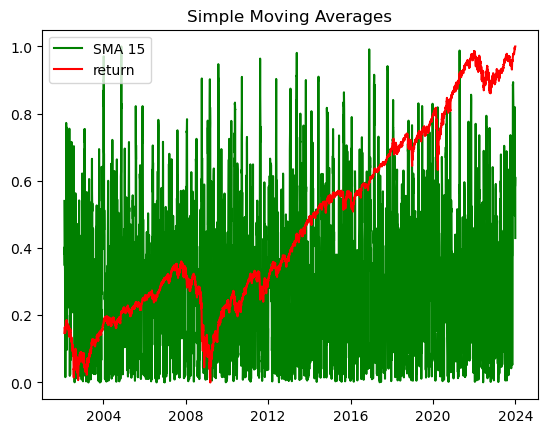

In [145]:
plt.plot(scaled_df['dmi'], color='green', label='SMA 15')
plt.plot(scaled_df['return'], color='red', label='return')
plt.legend()
plt.title('Simple Moving Averages')
plt.show()

WFO : walk- forward optimization
|X||V|O|O|O|
|O|X||V|O|O|
|O|O|X||V|O|
|O|O|O|X||V|

X = train, V = validation , ||=indicates a gap (parameter n_gap: int>0) truncated at the beginning of the validation set, in order to prevent leakage effects.

In [18]:
# WFO : walk- forward optimization
class StratifiedWalkForward(object):
    
    def __init__(self,n_splits,n_gap):
        self.n_splits = n_splits
        self.n_gap = n_gap
        self._cv = StratifiedKFold(n_splits=self.n_splits+1,shuffle=False)
        return
    
    def split(self,X,y,groups=None):
        splits = self._cv.split(X,y)
        _ixs = []
        for ix in splits: 
            _ixs.append(ix[1])
        for i in range(1,len(_ixs)): 
            yield tuple((_ixs[i-1],_ixs[i][_ixs[i]>_ixs[i-1][-1]+self.n_gap]))
            
    def get_n_splits(self,X,y,groups=None):
        return self.n_splits

# numFold = 5
# lC = list(np.linspace(0.0005, 1.5, 15))
# numC = len(lC)
# mACC = np.zeros(shape = (numFold, numC)) #<! Accuracy per Fold and Model

# for ii, (vTrainIdx, vTestIdx) in enumerate(StratifiedWalkForward.split(mX, vY)):
#     print(f'Working on Fold #{(ii + 1):02d} Out of {numFold} Folds')
#     #===========================Fill This===========================#
#     # Setting the Train / Test split
#     mXTrain = mX[vTrainIdx, :]
#     vYTrain = vY[vTrainIdx]
#     mXTest  = mX[vTestIdx, :]
#     vYTest  = vY[vTestIdx]
#     #===============================================================#
#     for jj, C in enumerate(lC):
#         print(f'Working on Model #{(jj + 1):02d} Out of {numC} Models with C = {C:0.4f}')
#         #===========================Fill This===========================#
#         # Set the model, train, score
#         # Set `max_iter = maxItr`
#         # Set `dual = False`
#         oSvmCls     = ???
#         # oSvmCls     = SVC(C = C)
#         oSvmCls     = ???
#         accScore    = ???
#         #===============================================================#
#         mACC[ii, jj] = accScore
    
# vAvgAcc = np.mean(mACC, axis = 0) #<! Accuracy

# Plot Results

# hF, hA = plt.subplots(figsize = (8, 8))
# hA.plot(lC, vAvgAcc)
# hA.scatter(lC, vAvgAcc, s = 100)
# hA.set_title(f'Accuracy Score as a Function of C - Average of {numFold} Folds')
# hA.set_xlabel('C')
# hA.set_ylabel('Accuracy')
# hA.set_xticks(lC)
# hA.grid()

# plt.show()

In [157]:
def build_rolling_calendar(start_date, end_date, out_of_sample_size, runs, n_gap):
    days = (end_date - start_date).days

    in_sample_size = (100 - out_of_sample_size) / 100
    out_of_sample_size = out_of_sample_size / 100

    total_days_per_run = round(days / (runs * out_of_sample_size + in_sample_size))
    in_sample_days_per_run = round(total_days_per_run * in_sample_size)
    out_of_sample_days_per_run = round(total_days_per_run * out_of_sample_size)

    calendar = pd.DataFrame()

    calendar['InSampleStarts'] = [start_date + timedelta(days=(out_of_sample_days_per_run * x))
                                  for x in range(runs)]
    calendar['InSampleEnds'] = [x + timedelta(days=in_sample_days_per_run)
                                for x in calendar['InSampleStarts']]

    calendar['OutSampleStarts'] = [start_date + timedelta(days=in_sample_days_per_run + n_gap) +
                                   timedelta(days=(out_of_sample_days_per_run * x))
                                   for x in range(runs)]
    calendar['OutSampleEnds'] = [x + timedelta(days=out_of_sample_days_per_run)
                                 for x in calendar['OutSampleStarts']]

    return calendar

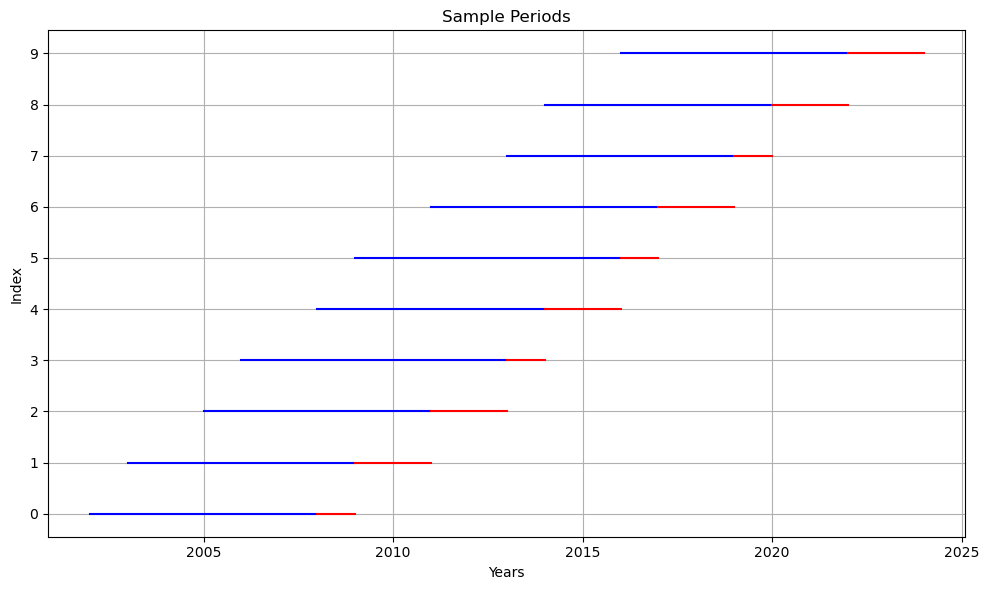

In [158]:
groups = 10
train = np.array(scaled_df)
X, y = train[:, :-1], train[:, -1]
calendar = build_rolling_calendar(start_date=scaled_df.index.min(), end_date=scaled_df.index.max(), out_of_sample_size=20, runs=10, n_gap=20)


# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

for i, row in calendar.iterrows():
    ax.plot([row['InSampleStarts'].year, row['InSampleEnds'].year], [i, i], color='blue')
    ax.plot([row['OutSampleStarts'].year, row['OutSampleEnds'].year], [i, i], color='red')

# Customize plot
ax.set_yticks(calendar.index.values[::-1])
ax.set_yticklabels(calendar.index.values[::-1])
ax.set_xlabel('Years')
ax.set_ylabel('Index')
ax.set_title('Sample Periods')
ax.grid(True)

plt.tight_layout()
plt.show()

In [90]:
calendar

,InSampleStarts,InSampleEnds,OutSampleStarts,OutSampleEnds
0,2002-01-30,2011-10-27,2011-11-16,2014-04-23
1,2004-07-07,2014-04-03,2014-04-23,2016-09-28
2,2006-12-13,2016-09-08,2016-09-28,2019-03-06
3,2009-05-20,2019-02-14,2019-03-06,2021-08-11
4,2011-10-26,2021-07-22,2021-08-11,2024-01-17


In [184]:
X_train = []
X_test = []
y_train = []
y_test = []
for i, row in calendar.iterrows():
    train = scaled_df.loc[row['InSampleStarts']: row['InSampleEnds']].to_numpy()
    X_train.append(train[:, :-1])
    y_train.append(train[:, -1])
    test = scaled_df.loc[row['OutSampleStarts']: row['OutSampleEnds']].to_numpy()
    X_test.append(test[:, :-1])
    y_test.append(test[:,-1])
    if i == 0: 
        X_train_signals = scaled_df.loc[row['OutSampleStarts']:].to_numpy()


flattened_y_test = np.array(list(chain(*y_test)))


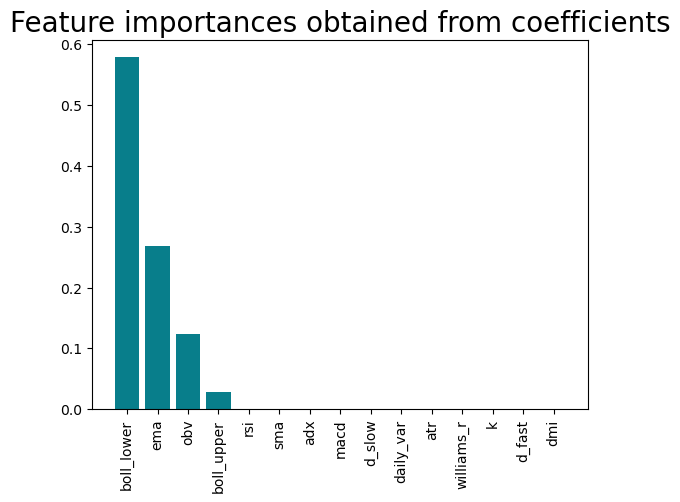

In [160]:
# Check first xgboost feature importance:
from xgboost import XGBRegressor
# train =  scaled_df.to_numpy()
# X_train_scaled, y_train = train[:, :-1], train[:, -1]

for i in range(len(X_train)):
    model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
    model.fit(X_train[i], y_train[i])
importances = pd.DataFrame(data={
    'Attribute': scaled_df.iloc[:, :-1].columns,
    'Importance': model.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

In [121]:

class RegressionModel:
    def __init__(self, model: Union[LinearRegression, SVR, RandomForestRegressor, 
                                     GradientBoostingRegressor, MLPRegressor, DecisionTreeRegressor]):
        self.model = model
    
    def train(self, X_train: np.ndarray, y_train: np.ndarray) -> None:
        self.model.fit(X_train, y_train)
    
    def predict(self, X_test: np.ndarray) -> np.ndarray:
        return self.model.predict(X_test)
    
    def score(self, y_pred: np.ndarray, y_test: np.ndarray) -> float:
        # Symmetric Mean Absolute Percentage Error (SMAPE)
        smape = 100/len(y_pred) * np.sum(2 * np.abs(y_test - y_pred) / (np.abs(y_pred) + np.abs(y_test)))
        #  SMAPE is a well-known and efficient testing parameter based on percentage errors or relative errors. The
        # lower the value of SMAPE, the higher the predictive accuracy of a given model.
        return 100 - smape
    

# Define specific regression models as subclasses
class LinearRegressionModel(RegressionModel):
    def __init__(self) -> None:
        super().__init__(LinearRegression())

class SVRModel(RegressionModel):
    def __init__(self) -> None:
        super().__init__(SVR())

class RandomForestRegressionModel(RegressionModel):
    def __init__(self) -> None:
        super().__init__(RandomForestRegressor())

class GradientBoostingRegressionModel(RegressionModel):
    def __init__(self) -> None:
        super().__init__(GradientBoostingRegressor())

class NeuralNetworkRegressionModel(RegressionModel):
    def __init__(self) -> None:
        super().__init__(MLPRegressor())

class DecisionTreeRegressionModel(RegressionModel):
    def __init__(self, max_depth: Optional[int] = None, random_state: Optional[int] = None) -> None:
        super().__init__(DecisionTreeRegressor(max_depth=max_depth, random_state=random_state))


In [170]:

svr_y_pred = []
svr = SVRModel()
for i in range(len(X_train)):
    svr.train(X_train[i], y_train[i])
    y_pred = svr.predict(X_test[i])
    svr_y_pred.extend(y_pred)
    score = svr.score(y_pred, y_test[i])
    print(f'batch {i} has a score of {score}')
    
svr_score = svr.score(svr_y_pred,flattened_y_test)
print(f'Accuracy of SVRegression is {svr_score}')


batch 0 has a score of 75.8006047956708
batch 1 has a score of 90.27313813599092
batch 2 has a score of 78.67490678380423
batch 3 has a score of 58.01972966574648
batch 4 has a score of 73.48851842711059
batch 5 has a score of 75.24375354102892
batch 6 has a score of 77.21153607819191
batch 7 has a score of 82.78885825751998
batch 8 has a score of 78.87051538674149
batch 9 has a score of 90.52418335634164
Accuracy of SVRegression is 78.04449010594922


batch 0 has a score of 87.35113081214132
batch 1 has a score of 97.76309563647001
batch 2 has a score of 97.15506843923771
batch 3 has a score of 77.16483441497014
batch 4 has a score of 93.4818896645793
batch 5 has a score of 92.90632085165814
batch 6 has a score of 93.25132003386084
batch 7 has a score of 94.43969825375657
batch 8 has a score of 89.54596594680449
batch 9 has a score of 99.09525899504305
Accuracy of Decision Tree Regression Model is 92.1886937063548


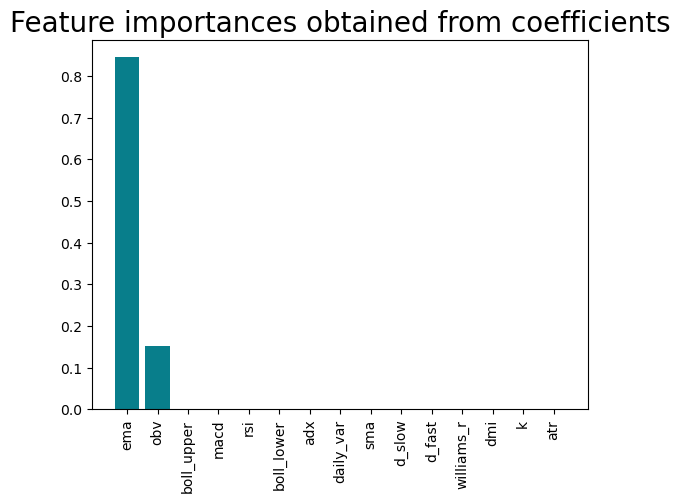

In [163]:
dtr_y_pred = []
dtr = DecisionTreeRegressionModel()
for i in range(len(X_train)):
    dtr.train(X_train[i], y_train[i])
    y_pred = dtr.predict(X_test[i])
    dtr_y_pred.extend(y_pred)
    score = dtr.score(y_pred, y_test[i])
    print(f'batch {i} has a score of {score}')
    
dtr_score = dtr.score(dtr_y_pred,flattened_y_test)
print(f'Accuracy of Decision Tree Regression Model is {dtr_score}')


importances = pd.DataFrame(data={
    'Attribute': scaled_df.iloc[:, :-1].columns,
    'Importance': dtr.model.tree_.compute_feature_importances()
})
importances = importances.sort_values(by='Importance', ascending=False)
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

batch 0 has a score of 92.50331921056785
batch 1 has a score of 98.56547942093198
batch 2 has a score of 97.43334882095108
batch 3 has a score of 78.12776682582444
batch 4 has a score of 94.22613762619555
batch 5 has a score of 92.30927466822739
batch 6 has a score of 92.47020077203567
batch 7 has a score of 94.19546105310685
batch 8 has a score of 89.40570115424313
batch 9 has a score of 95.01410001551692
Accuracy of Gradient Boosting Regression Model is 92.41488781090078


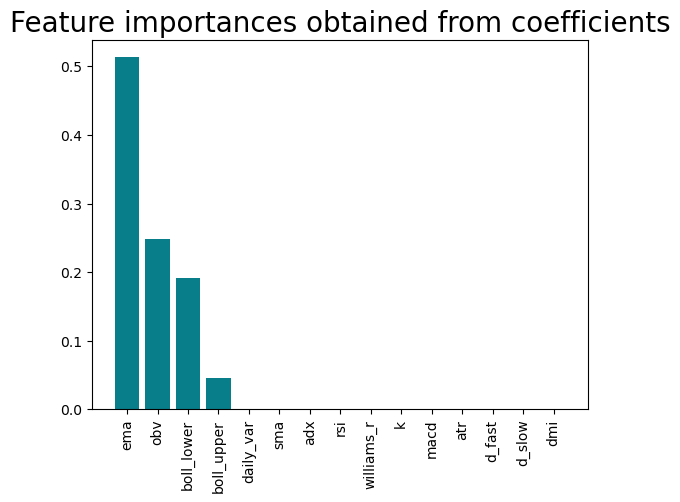

In [164]:
gbr_y_pred = []
gbr = GradientBoostingRegressionModel()
for i in range(len(X_train)):
    gbr.train(X_train[i], y_train[i])
    y_pred = gbr.predict(X_test[i])
    gbr_y_pred.extend(y_pred)
    score = gbr.score(y_pred, y_test[i])
    print(f'batch {i} has a score of {score}')
    
gbr_score = gbr.score(gbr_y_pred,flattened_y_test)
print(f'Accuracy of Gradient Boosting Regression Model is {gbr_score}')

importances = pd.DataFrame(data={
    'Attribute': scaled_df.iloc[:, :-1].columns,
    'Importance': gbr.model.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

batch 0 has a score of 90.6683361253312
batch 1 has a score of 98.59084103028516
batch 2 has a score of 97.4923834177535
batch 3 has a score of 78.77635491956225
batch 4 has a score of 93.89765860105594
batch 5 has a score of 92.62404277786067
batch 6 has a score of 93.12533548798561
batch 7 has a score of 94.21390007329951
batch 8 has a score of 89.53463144780511
batch 9 has a score of 98.81208913233594
Accuracy of Random Forest Regression Model is 92.7508759949651


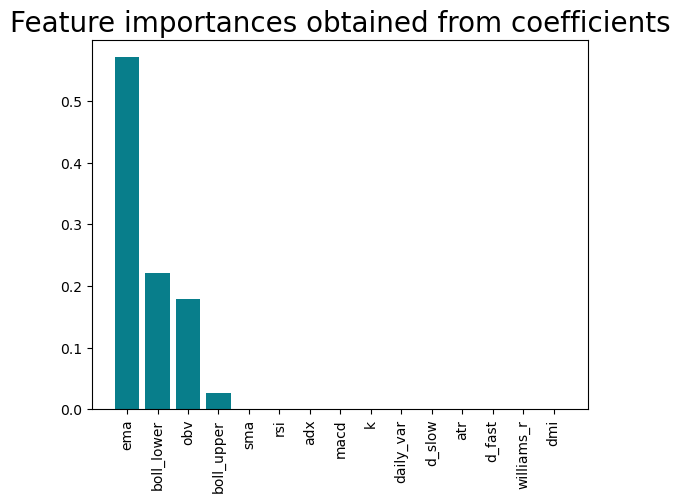

In [167]:
rfr_y_pred = []
rfr = RandomForestRegressionModel()
for i in range(len(X_train)):
    rfr.train(X_train[i], y_train[i])
    y_pred = rfr.predict(X_test[i])
    rfr_y_pred.extend(y_pred)
    score = rfr.score(y_pred, y_test[i])
    print(f'batch {i} has a score of {score}')
    
rfr_score = rfr.score(rfr_y_pred,flattened_y_test)
print(f'Accuracy of Random Forest Regression Model is {rfr_score}')

importances = pd.DataFrame(data={
    'Attribute': scaled_df.iloc[:, :-1].columns,
    'Importance': rfr.model.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

In [185]:
len(X_train_signals)

3923

In [174]:
signals =  calculate_signals(y_pred=rfr_y_pred, q_low=0.4, q_high=0.6)
len(signals)

3927